In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

In [2]:
datapath = 'Fantasy-Premier-League-master/data/2022-23/'
#last_season_datapath = 'Fantasy-Premier-League-master/data/2021-22/'

In [3]:
fixture_df = pd.read_csv(datapath+'fixtures.csv')
team_df = pd.read_csv(datapath+'teams.csv')
gw_df = pd.read_csv(datapath+'gws/merged_gw.csv')

In [4]:
#gw_df.sort_values(by=['name','threat','opponent_team'])
#gw_df['opponent_team']
#fixture_df.sort_values('team_h_difficulty')
#fixture_df.head()

In [5]:
gw_df = gw_df[['name', 'team', 'minutes', 'creativity', 'fixture', 'influence', 'opponent_team',
       'threat', 'total_points', 'was_home', 'GW']]
team_df = team_df[['id', 'name']]
fixture_df = fixture_df[['event', 'id', 'team_a', 'team_h', 'team_h_difficulty', 'team_a_difficulty']]

In [6]:
gw_df = gw_df.drop(gw_df[gw_df.minutes==0].index)

In [7]:
# Interested in adding: past 5 GW average points, past 5 GW ICT, (total) fixture difficulty gap, something from last season
# Need to link: fixture data
# Target: next 5 GW average points
# Evaluate: MSE among TopX-scoring players?
gw_df = gw_df.merge(team_df, left_on='team', right_on='name').rename(columns={'id':'player_team'}).drop(columns={'team', 'name_y'})
gw_df = gw_df.merge(fixture_df, left_on='fixture', right_on='id')
gw_df.head()

,name_x,minutes,creativity,fixture,influence,opponent_team,threat,total_points,was_home,GW,player_team,event,id,team_a,team_h,team_h_difficulty,team_a_difficulty
0,Nathan Redmond,1,0.0,8,0.0,18,0.0,1,False,1,17,1,8,17,18,2,4
1,Roméo Lavia,90,4.3,8,12.0,18,8.0,2,False,1,17,1,8,17,18,2,4
2,Joe Ayodele-Aribo,90,5.2,8,9.4,18,23.0,2,False,1,17,1,8,17,18,2,4
3,Stuart Armstrong,45,2.6,8,3.4,18,0.0,1,False,1,17,1,8,17,18,2,4
4,Oriol Romeu Vidal,74,3.8,8,6.2,18,2.0,2,False,1,17,1,8,17,18,2,4


In [8]:
def get_difficulty_gap(row):
    if row.player_team == row.team_h:
        return row.team_h_difficulty - row.team_a_difficulty
    else:
        return row.team_a_difficulty - row.team_h_difficulty

def get_prev_stats(row):
    history = 5
    if row.GW <= history:
        return -1, -1, -1, -1
    player_history = gw_df[(gw_df.name_x == row.name_x) & ((gw_df.GW >= row.GW - history) & (gw_df.GW < row.GW))]
    return player_history.creativity.mean(), player_history.influence.mean(), player_history.threat.mean(), player_history.total_points.mean()

In [9]:
prev_stats = gw_df.apply(get_prev_stats, axis=1, result_type='expand').rename(columns={0:'prev_avg_c', 1:'prev_avg_i', 2:'prev_avg_t', 3:'prev_avg_score'})
prev_stats.fillna(0, inplace=True)
gw_df = pd.concat([gw_df, prev_stats], axis=1)

In [10]:
gw_df['difficulty_gap'] = gw_df.apply(get_difficulty_gap, axis=1)

In [12]:
gw_df = gw_df[['was_home', 'GW',
       'prev_avg_score', 'prev_avg_c', 'prev_avg_i', 'prev_avg_t', 'difficulty_gap', 'total_points']]

gw_df = gw_df[gw_df.GW > 5]
gw_df = pd.get_dummies(gw_df)

In [13]:
gw_df.head(-5)

,was_home,GW,prev_avg_score,prev_avg_c,prev_avg_i,prev_avg_t,difficulty_gap,total_points
148,False,6,4.500000,16.300000,21.150000,29.250000,0,2
149,False,6,2.600000,4.820000,13.120000,26.400000,0,2
150,False,6,1.250000,11.600000,4.300000,6.500000,0,1
151,False,6,0.600000,3.780000,16.760000,6.400000,0,2
152,False,6,2.000000,4.800000,8.133333,11.666667,0,1
...,...,...,...,...,...,...,...,...
11335,False,24,2.666667,29.000000,15.300000,12.833333,-2,2
11336,False,24,1.800000,8.720000,15.480000,1.800000,-2,5
11337,False,24,2.666667,17.533333,12.266667,7.500000,-2,7
11338,False,24,2.250000,7.125000,11.250000,17.500000,-2,2


In [14]:
X = gw_df.drop('total_points', axis=1)
y = gw_df.total_points

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [15]:
clf = linear_model.Ridge(alpha=10)

In [16]:
clf.fit(X_train, y_train)

Ridge(alpha=10)

In [17]:
preds = clf.predict(X_val)
mean_squared_error(y_val, preds)

7.72653639211607

In [25]:
mean_squared_error(y_val, X_val.prev_avg_score)

9.785669545624158

In [18]:
pd.DataFrame([clf.feature_names_in_, clf.coef_]).T

,0,1
0,was_home,0.300892
1,GW,0.00222
2,prev_avg_score,0.111006
3,prev_avg_c,0.014598
4,prev_avg_i,0.030841
5,prev_avg_t,0.01961
6,difficulty_gap,-0.302467


In [23]:
compare = pd.DataFrame([y_val.values, X_val.prev_avg_score, preds]).T.sort_values(by=0)

In [24]:
compare

,0,1,2
1101,-3.0,3.20,3.101230
408,-3.0,0.00,1.953007
882,-3.0,3.00,2.550318
1268,-3.0,2.00,2.305971
1071,-2.0,5.00,2.908719
...,...,...,...
1931,15.0,2.25,3.342699
682,16.0,6.40,4.499289
1323,17.0,5.60,4.401703
1021,18.0,4.40,3.861323


<Axes: >

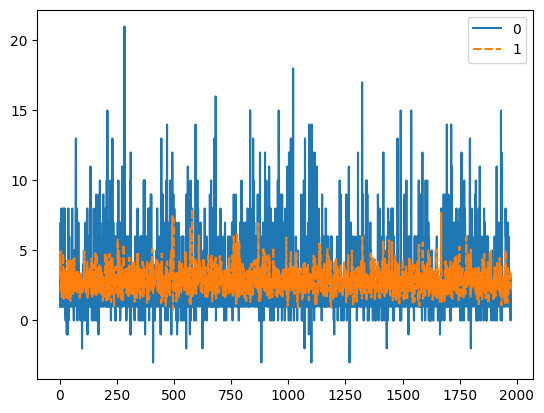

In [20]:
sns.lineplot(data=compare)